# Publication plots & statistics
Combination of all the plots in the other notebooks. These will be the main plots in the manuscript

In [1]:
#Figure size global settings
def mm_to_inches(mm):
    return mm * 0.0393701
one_column = mm_to_inches(86)
two_column = mm_to_inches(178)
print(one_column, two_column)

3.3858286 7.007877799999999


### Loss data and orthogroup data stats

In [2]:
import pandas as pd
import numpy as np

file = "./Results/Stats.csv"

ortho_stats = pd.read_csv(file, sep = ",", index_col = 0, header = 0)
ortho_stats.iloc[:,1:-1].astype(float)
ortho_data = ortho_stats.to_dict('index')
stats = list(ortho_data.keys())
print(stats)

['Number OGs', 'Median size OGs', 'Mean size OGs', 'Mean size OGs stdev', 'Maximum size OGs', 'Independent loss OGs', 'Median indep. loss OGs', 'Mean indep. loss OGs', 'Mean indep. loss OGs stdev']


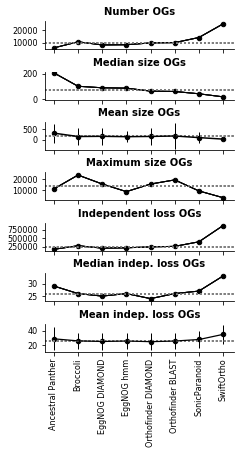

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import statistics as s
import math as m
from matplotlib.ticker import ScalarFormatter

def make_plot(stat, ax, ortho_data, ticks_on = "no"):
    for ogdef, value in ortho_data[stat].items():
        
        ogdefs = list(ortho_data[stat].keys())
        values = list(ortho_data[stat].values())
        median = s.median(values)
        
        ax.scatter(ogdef, value,color = "black", s = 20) #'#7F3C8D'
        if stat not in ['Mean size OGs', 'Mean indep. loss OGs']:
            ax.plot(ogdefs, values,color = "black", linewidth = 1, alpha = 0.5) #'#7F3C8D'
        ax.axhline(median, linestyle = "dotted", color = '#808080')
        ax.set_title(stat, fontweight="bold", fontsize = 10)
        if ticks_on == "no":
            ax.set_xticklabels([''])
        else:
            ax.tick_params(axis='x', rotation=90, labelsize = 8)
        ax.tick_params(axis='y', labelsize = 8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


    return ogdefs, values

stat = list(ortho_data.keys())

fig = plt.figure(figsize = (one_column, 1*two_column))
gs = fig.add_gridspec(8, 1)

ax = fig.add_subplot(gs[0,0]) 
make_plot(stats[0], ax, ortho_data)

ax1 = fig.add_subplot(gs[1,0]) 
make_plot(stats[1], ax1, ortho_data)
    
ax2 = fig.add_subplot(gs[2,0]) 
og, val = make_plot(stats[2], ax2, ortho_data)
stdev = []
og_i = []
for ogdef in og:
    stdev += [ortho_data[stats[3]][ogdef]]
    og_i += [og.index(ogdef)]
ax2.errorbar(og_i, val,\
            yerr = stdev, fmt="-", color = "black", elinewidth = 1, lw = 1.5)#'#7F3C8D'

ax3 = fig.add_subplot(gs[3,0]) 
make_plot(stats[4], ax3, ortho_data)

ax4 = fig.add_subplot(gs[4,0]) 
make_plot(stats[5], ax4, ortho_data)

ax5 = fig.add_subplot(gs[5,0]) 
make_plot(stats[6], ax5, ortho_data)

ax6 = fig.add_subplot(gs[6,0]) 
og2, val2 = make_plot(stats[7], ax6, ortho_data, ticks_on = True)
stdev2 = []
og_i2 = []
for ogdef in og2:
    stdev2 += [ortho_data[stats[8]][ogdef]]
    og_i2 += [og.index(ogdef)]
ax6.errorbar(og_i2, val2,\
            yerr = stdev2, fmt="-", color = "black", elinewidth = 1, lw =1.25)#'#7F3C8D'
plt.subplots_adjust(hspace=0.8, wspace = 0.3)


file_name='./Figures/Manuscript/stats_LECA.pdf'
plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format = 'pdf',transparent = True)

### Loss distribution

In [1]:
import pandas as pd
import numpy as np

dir_name = "./Results/Loss/"

loss_file = ["egg_DIAMOND_loss",\
                 "egg_hmm_loss_corrected",\
                 "ortho_diamond_loss",\
                 "ortho_em3_loss",\
                 "Panther_em3_loss_different",\
                 "broccoli_loss",\
                 "Sonicparanoid_sensitive_loss",\
                 "swiftortho_c50_loss"]

loss_file_list = [dir_name+file for file in loss_file]

dframe_dict = {}
for file in loss_file_list:
    file_name = file.split("/")[-1]
    dframe_dict[file_name] = pd.read_csv(file, sep = "\t", header = None, names = ["IDs", "loss"], index_col = 0)
    dframe_dict[file_name].loc[:,'loss'].astype(float)

re_names = {'broccoli_loss': 'Broccoli',\
            'egg_DIAMOND_loss': 'eggNOG DIAMOND',\
            'egg_hmm_loss_corrected': 'eggNOG hmm',\
            'ortho_diamond_loss': 'Orthofinder DIAMOND',\
            'ortho_em3_loss': ' '.join(['Orthofinder BLAST', r'$10^{-3}$']),\
            'Panther_em3_loss_different': 'Ancestral Panther',\
            'Sonicparanoid_sensitive_loss': 'SonicParanoid sensitive',\
            'swiftortho_c50_loss': 'SwiftOrtho'}

#rename file names to publciation names
dframe_dict = {re_names[k]:v for k,v in dframe_dict.items()}

In [17]:
from scipy.stats import mannwhitneyu, kruskal, wilcoxon
from itertools import combinations
#Mann-Whitney U Test to test if distributions are equal or not
#Assumptions
#
#    Observations in each sample are independent and identically distributed (iid).
#    Observations in each sample can be ranked.

#Interpretation

#    H0: the distributions of both samples are equal o that there is a 50% 
#probability that an observation from a value randomly selected from one population 
#exceeds an observation randomly selected from the other population.
#    H1: the distributions of both samples are not equal.
#If the P value is small, you can reject the null hypothesis that the difference 
#is due to random sampling, and conclude instead that the populations are distinct.

combis = combinations(dframe_dict.keys(),2)
for pairs in combis:
    name1 = pairs[0]
    name2 = pairs[1]
    data1, data2 = dframe_dict[name1].loc[:,'loss'].astype(float),\
    dframe_dict[name2].loc[:,'loss'].astype(float)
    
    stat, p = mannwhitneyu(data1, data2)
    stat2, p2 = kruskal(data1, data2)
    #significantly not dissimilar
    if p > 0.001:
        print("mannwhitney: ", pairs,'\t', '\t', p)

    if p2 > 0.001:
        print("kruskal: ", pairs,'\t', '\t', p2)

mannwhitney:  ('eggNOG DIAMOND', 'Orthofinder DIAMOND') 	 	 0.06935063017476177
kruskal:  ('eggNOG DIAMOND', 'Orthofinder DIAMOND') 	 	 0.1387008869592725
mannwhitney:  ('eggNOG hmm', 'Orthofinder BLAST $10^{-3}$') 	 	 0.4640628364016168
kruskal:  ('eggNOG hmm', 'Orthofinder BLAST $10^{-3}$') 	 	 0.9281245986809202
mannwhitney:  ('eggNOG hmm', 'Broccoli') 	 	 0.08904229807803066
kruskal:  ('eggNOG hmm', 'Broccoli') 	 	 0.178084179611817
mannwhitney:  ('Orthofinder BLAST $10^{-3}$', 'Broccoli') 	 	 0.0694024024449574
kruskal:  ('Orthofinder BLAST $10^{-3}$', 'Broccoli') 	 	 0.13880450227039395


Ancestral Panther
Broccoli
eggNOG DIAMOND
eggNOG hmm
Orthofinder BLAST $10^{-3}$
Orthofinder DIAMOND
SonicParanoid sensitive
SwiftOrtho


/Users/eva/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/eva/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/eva/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlie

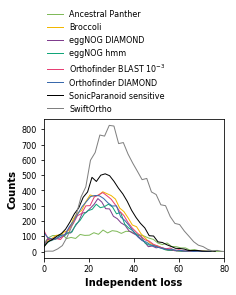

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import statistics as s
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.metrics import auc

colors2 = ['#7F3C8D', '#11A579','#3969AC','#F2B701','#E73F74','#80BA5A', '#000000', '#808080','#c0ff33','#ff9033']

colors = {'eggNOG DIAMOND': colors2[0],\
          'eggNOG hmm':colors2[1],\
          'Orthofinder DIAMOND':colors2[2],\
          'Orthofinder BLAST $10^{-3}$':colors2[4],\
          'Ancestral Panther':colors2[5],\
          'Broccoli': colors2[3],
          'SonicParanoid sensitive': colors2[6],\
          'SwiftOrtho': colors2[7]}

i = 0
fig = plt.figure(figsize = (one_column, 1.25*one_column))
for orthos in sorted(dframe_dict.keys(), key=str.lower):
    print(orthos)
    i+=1
    ax = fig.add_subplot(1,1,1)
    current = dframe_dict[orthos]
    loss = current.loc[:,'loss']
    loss_sum = sum(loss)
    lc = loss.value_counts().sort_index() #count per loss value and sort on loss (index)
    lcd = pd.DataFrame({'loss': lc.index, 'counts': lc.values}) #make df to work with
    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(lcd.loc[:,'loss'].min(), lcd.loc[:,'loss'].max(), 40)  
    spl = make_interp_spline(lcd.loc[:,'loss'], lcd.loc[:,'counts'], k = 3)
    power_smooth = spl(xnew)
    
    ax.plot(xnew, power_smooth ,linewidth=1, color = colors[orthos], label = orthos)

plt.ylabel("Counts", size=10, fontweight = "bold")
plt.xlabel('Independent loss',  size=10, fontweight = "bold")
plt.legend(loc = 3, ncol = 1, prop={'size': 8}, mode = 'expand', bbox_to_anchor = (0., 1.02, 1., .102),\
           borderaxespad=0., frameon = False)

plt.yticks(np.arange(0, 801, step=100), size = 8)
plt.xticks(size = 8)
plt.xlim(0,80)
plt.tight_layout()

import os.path
from os import path
file_name='./Figures/Manuscript/lossDistributions.pdf'
plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format = 'pdf',transparent = True)

### Distance distribution

In [5]:
import pandas as pd
file_dir = "./Results/Distances/"
files = ["egg_distances_5pubID",\
        "egg_hmm_distances_5pubID_corrected",\
        "od_distances_5pubID",\
        "om3_distances_5pubID",\
        "broccoli_distances_5pubID",\
        "panther_distances_5pubID_different",\
        "sonicparanoid_sensitive_distances_5pubID",\
        "swiftortho_c50_distances_5pubID"]

file_list = ["".join([file_dir, el]) for el in files]

#make dictionary with all the dataframes
data_dict = {}
for i in range(len(file_list)):
    file = file_list[i]
    name = file.split("/")[-1]
    print(i, name)
    #only read in cosine and Pseudo negative set. 
    data_dict[name] = pd.read_csv(file, sep = "\t", index_col = False, \
                                  usecols=['pair', 'cosine', 'Interaction']).query('Interaction != "RusselNeg"')
    data_dict[name].loc[:,'cosine'].astype(float)


0 egg_distances_5pubID
1 egg_hmm_distances_5pubID_corrected
2 od_distances_5pubID
3 om3_distances_5pubID
4 broccoli_distances_5pubID
5 panther_distances_5pubID_different
6 sonicparanoid_sensitive_distances_5pubID
7 swiftortho_c50_distances_5pubID


In [6]:
# rename distance files
re_names_dict = {'egg_distances_5pubID': 'eggNOG DIAMOND',\
'egg_hmm_distances_5pubID_corrected': 'eggNOG hmm',\
'od_distances_5pubID': 'Orthofinder DIAMOND',\
'om3_distances_5pubID': 'Orthofinder BLAST',\
'broccoli_distances_5pubID': 'Broccoli',\
'panther_distances_5pubID_different': 'Ancestral Panther',\
'sonicparanoid_sensitive_distances_5pubID': 'SonicParanoid',\
'swiftortho_c50_distances_5pubID': 'SwiftOrtho'}

data_dict = {re_names_dict[k]:v for k, v in data_dict.items()}


### ROC plot comparing orthologies and their predictive power + Distance distribution

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
fpr = {}
tpr = {}
auc_d = {}
t = {}


i = 0
for name in data_dict:
    i+=1
    print(i, name)
    max_r=max(data_dict[name]['cosine'])
    fpr[name], tpr[name], t[name] = roc_curve(data_dict[name]["Interaction"], [max_r - x for x in data_dict[name]['cosine']], pos_label="BioGrid")
    auc_d[name] = auc(fpr[name],tpr[name])
    

1 eggNOG DIAMOND
2 eggNOG hmm
3 Orthofinder DIAMOND
4 Orthofinder BLAST
5 Broccoli
6 Ancestral Panther
7 SonicParanoid
8 SwiftOrtho


In [23]:
#Calculated sepperatly because it takes a lot of time to do the permuations for all of them. 
c_ints = {'Orthofinder DIAMOND': [0.7162752,0.74101984], 'eggNOG DIAMOND': [0.69875282,0.72409355],\
          'eggNOG hmm': [0.71558598,0.74127035], 'SwiftOrtho': [0.58618667,0.6197706],\
          'Orthofinder BLAST': [0.72763392,0.75151731], 'Ancestral Panther': [0.66821444,0.68935625],\
          'Broccoli': [0.71479168,0.73976344], 'SonicParanoid': [0.72127248,0.74541354]}

colors2 = ['#7F3C8D', '#11A579','#3969AC','#F2B701','#E73F74','#80BA5A', '#000000', '#808080','#c0ff33','#ff9033']

colors = {'eggNOG DIAMOND': colors2[0],\
          'eggNOG hmm':colors2[1],\
          'Orthofinder DIAMOND':colors2[2],\
          'Orthofinder BLAST':colors2[4],\
          'Ancestral Panther':colors2[5],\
          'Broccoli': colors2[3],
          'SonicParanoid': colors2[6],\
          'SwiftOrtho': colors2[7]}

Orthofinder BLAST
SonicParanoid
Orthofinder DIAMOND
eggNOG hmm
Broccoli
eggNOG DIAMOND
Ancestral Panther
SwiftOrtho


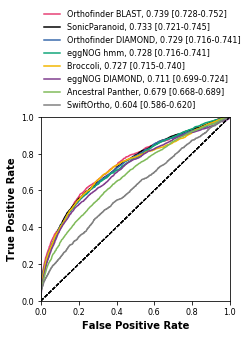

In [24]:
%matplotlib inline
import statistics as s
import numpy as np
import operator
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

labels = ['']
i = 0
fig = plt.figure(figsize = (one_column,1*one_column))

for columns in sorted(auc_d.items(), key=operator.itemgetter(1), reverse = True):
    column = columns[0]
    label = "%s, %0.3f [%0.3f-%0.3f]" % (column, auc_d[column], c_ints[column][0], c_ints[column][1])
    print(column)
    plt.plot(fpr[column], tpr[column], color = colors[column], label = label)#, linestyle = linestyle[i], linewidth=3.0, alpha = alpha[i]
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    i+=1

plt.ylabel("True Positive Rate", size=10, fontweight = "bold")
plt.xlabel("False Positive Rate", size=10, fontweight = "bold") 

plt.legend(loc = 3, ncol = 1, prop={'size': 8}, mode = 'expand', bbox_to_anchor = (0., 1.02, 1., .102),\
           borderaxespad=0., frameon = False)
        
plt.yticks(np.arange(0, 1.1, step=0.2), size = 8)
plt.xticks(np.arange(0, 1.1, step=0.2), size = 8)
plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout

file_name = "./Figures/Manuscript/Publication_ROC.pdf"
plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format='pdf',\
                transparent = True)

### Load database data

In [21]:
import re
from sklearn.metrics import adjusted_rand_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import sys

##EUKARYA PATH (in bashrc(-user) or bash-profile)
#export EUKARYA_PATH='/full/path/to/database/eukarya/'
#export PYTHONPATH=$PYTHONPATH:'/full/path/to/database/eukarya/scripts/'
#database from John's private git repo, scripts and needed database to run following code is available
import eukarya
# Load the specific table objects
from eukarya.database import Species, Proteins, Genes, engine, Session, get_orthology_leca_tables

# Setting up the logger
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
#logger.setLevel("DEBUG")


In [22]:
session = Session()  # Start DB session

In [23]:
def loadOrthologies(table):
    ''' Loads the orthology table into a dictionary. '''
    og_dict = dict()
    query = session.query(table.gene_id,table.og_id).distinct()
    logger.info(query.statement)
    for gene_id,og_id in query.all():
        og_dict[gene_id] = og_id
    return og_dict

def loadLECAOrthologies(table,leca_table):
    ''' Loads the leca filtered orthology table into a dictionary. '''
    og_dict = dict()
    query = session.query(table.gene_id,table.og_id).join(leca_table).distinct()
    logger.info(query.statement)
    for gene_id,og_id in query.all():
        og_dict[gene_id] = og_id
    return og_dict


In [24]:
# Load the orthologies unfiltered for LECA OGs

Orthologies = dict()
for orthodef,tables in get_orthology_leca_tables().items():
    #if orthodef not in skip_list:
    Orthologies[orthodef] = loadOrthologies(tables[0])

# Load the orthologies filtered for leca OGs
Orthologies_leca_ogs = dict()
for orthodef,tables in get_orthology_leca_tables().items():
    #if orthodef not in skip_list:
    Orthologies_leca_ogs[orthodef] = loadLECAOrthologies(tables[0],tables[1])

2020-05-12 10:46:26 INFO     SELECT DISTINCT annotations.orthofinder_diamond.gene_id, annotations.orthofinder_diamond.og_id 
FROM annotations.orthofinder_diamond
2020-05-12 10:46:40 INFO     SELECT DISTINCT annotations.eggnog_diamond.gene_id, annotations.eggnog_diamond.og_id 
FROM annotations.eggnog_diamond
2020-05-12 10:46:50 INFO     SELECT DISTINCT annotations.eggnog_hmmer_corrected.gene_id, annotations.eggnog_hmmer_corrected.og_id 
FROM annotations.eggnog_hmmer_corrected
2020-05-12 10:46:59 INFO     SELECT DISTINCT annotations.orthofinder_blast_3.gene_id, annotations.orthofinder_blast_3.og_id 
FROM annotations.orthofinder_blast_3
2020-05-12 10:47:13 INFO     SELECT DISTINCT annotations.panther_corrected.gene_id, annotations.panther_corrected.og_id 
FROM annotations.panther_corrected
2020-05-12 10:47:24 INFO     SELECT DISTINCT annotations.manual.gene_id, annotations.manual.og_id 
FROM annotations.manual
2020-05-12 10:47:24 INFO     SELECT DISTINCT annotations.broccoli.gene_id, anno

In [25]:
# Some lists of Orthologies keys for ease of use

# All the orthology definitions, including the Manual set
Orthologies_all = list(Orthologies.keys())

# All the to be tested orthology definitions
Orthologies_cropped = Orthologies_all.copy()
Orthologies_cropped.remove('manual')


### Grid plots

In [6]:
from seaborn import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

autumn = cm.rocket_r
newcolors = autumn(np.linspace(0.20, 0.8, 256))#[::-1]

white = np.array([1, 1, 1, 1])
newcolors[0, :] = white
newcmp = ListedColormap(newcolors)

[[0.96298491 0.6126247  0.45145074 1.        ]
 [0.96298491 0.6126247  0.45145074 1.        ]
 [0.96276513 0.60612062 0.44471698 1.        ]
 ...
 [0.30592213 0.11432553 0.29542718 1.        ]
 [0.29977678 0.11356089 0.29254823 1.        ]
 [0.29977678 0.11356089 0.29254823 1.        ]]


#### Example grid plot

/Users/eva/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


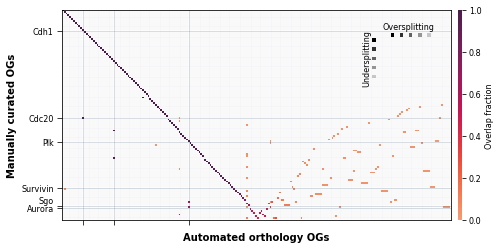

In [9]:
%matplotlib inline

from scipy.cluster.hierarchy import linkage, dendrogram
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import numpy as np

# Get the intersect in protein ids between all ogs
intersect = set(Orthologies_leca_ogs['manual'].keys())

for ogdef in Orthologies_cropped:
    intersect = intersect.intersection(set(Orthologies_leca_ogs[ogdef].keys()))
x_set1 = Orthologies_leca_ogs['manual'].copy()  # Lets define the x-axis set (Manual)

# Setup the figure with subplots
plt.rcParams.update({'font.size': 8})

fig = plt.figure(figsize=(two_column, two_column))

# Go through each of the other ones as the y-axis set and plot
for axis_id, ogdef in enumerate(Orthologies_cropped):
    ax = fig.add_subplot(1,1,1)
    y_set = Orthologies_leca_ogs[ogdef].copy()  # Define the y-axis set

    # Get the intersect between x and y only and ignore the intersect between all ogdefs
    intersect = set(x_set1.keys()).intersection(set(y_set.keys()))

    # Reduce the sets to the overlapping gene ids
    x_set = {k:v for k,v in x_set1.items() if k in intersect}
    y_set = {k:v for k,v in y_set.items() if k in intersect}
    def convert_dict(d):
        '''Convert the orthology dictionary to a set based dictionary'''
        new_d = dict()
        for key,value in d.items():
            if value in new_d:
                new_d[value].add(key)
            else:
                 new_d[value] = {key}
        return new_d

    # Converting dictionaries to a set based dictionary
    # NOTE: x and y are switched... Manual is actually on the y-axis...
    x_d = convert_dict(x_set)
    y_d = convert_dict(y_set)
    
    # Create empty matrix.
    matrix = np.zeros((len(x_d.keys()),len(y_d.keys())));
    matrix2 = np.zeros((len(x_d.keys()),len(y_d.keys())));
    names_man = ["" for x in range(len(x_d.keys()))]
    names_auto = ["" for x in range(len(y_d.keys()))]
    freq = list()

    # Filling the matrix with the size of the overlap for each x/y OG pair .
    for x,og_id_x in enumerate(sorted(x_d.keys())):
        for y,og_id_y in enumerate(sorted(y_d.keys())):
            names_man[x] = og_id_x
            names_auto[y] = og_id_y
            matrix[x,y] = len(x_d[og_id_x].intersection(y_d[og_id_y]))#/max([len(x_d[i]) for i in x_d.keys()])#/len(x_d[og_id_x])
            matrix2[x,y] = len(x_d[og_id_x].intersection(y_d[og_id_y]))/len(x_d[og_id_x])
            freq.append(len(x_d[og_id_x].intersection(y_d[og_id_y])))

    new_array = []
    max_index_coord = []
    rest_index = []
    max_val = []
    r_count = 0

    for row in matrix2:
        max_index = np.argmax(row)
        max_val += [row[max_index]] #the max value
        max_index_coord += [(max_index, r_count)]
        r_count+=1
    max_sorted = [max_index_coord[i] for i in np.argsort(max_val)][::-1]
    
    # Plotting the matrix
    
    dnx = []
    dny = []
    #from the max_sorted list containing the tuples, make two seperate lists
    for (col, row) in max_sorted:
        if col not in dnx: #multiple per column possible, but we want it only once
            dnx += [col]
        dny += [row]
        
    dnxl = []
    #for every column not in the diagonal, or the left over column, cluster them and then add
    for el in range(0, len(names_auto)):
        if el not in dnx:
            dnxl += [el]
    
    dnxl_linkage = linkage(matrix2[:,dnxl].transpose(), method='weighted', metric='euclidean', optimal_ordering=False) #cluster onlypart of the matrix
    dnxl_d = dendrogram(dnxl_linkage, no_plot = True) #leaves (restart counting)
    linked_dnxl = [dnxl[i] for i in dnxl_d['leaves']] #get the correct original column numbers

    dnx.extend(linked_dnxl)   
    
    matrix2 = matrix2[dny,:]
    matrix2 = matrix2[:,dnx]
    
    auto_wanted = ["OG0000505", "OG0000420", "OG0000006"]
    manual_wanted = ['Survivin', 'Aurora', 'Cdh1', 'Cdc20',  'Plk', 'Sgo']
        
    labs_x = [names_auto[i] for i in dnx]
    labs_y = [names_man[i] for i in dny]
        
    def filtering(wanted, labs):
            
        labs_filter = []
        count = -1   
        majors = []
        minors = []
        
        for label in labs:
            count += 1
            if label not in wanted:
                labs_filter += " "
                minors += [count] #minor tick marks
            else:
                labs_filter += [label]
                majors += [count] #major tick marks
                    
        return minors, majors, labs_filter
                    
    if ogdef == 'orthofinder_blast_e-3':
        
        
        minors_y, majors_y, labs_fy = filtering(manual_wanted, labs_y)
        minors_x, majors_x, _ = filtering(auto_wanted, labs_x)
        
        labs_fy = [word.replace("Sgo", " ") for word in labs_fy] #replace because label is overlapping

        im = ax.imshow(matrix2, cmap=newcmp, interpolation='nearest')
        
        # NOTE: x and y are switched. Manual is on the y-axis
        ax.set_ylabel("Manually curated OGs", fontsize = 10, fontweight = 'bold')
        ax.set_xlabel("Automated orthology OGs", fontsize = 10, fontweight = 'bold')

        ax.tick_params(which='major', width=0.75)
        ax.tick_params(which='major', length=5)
        ax.tick_params(which='minor', width=0) #0.75
        ax.tick_params(which='minor', length=0) #2.5
        
        ax.yaxis.set_major_locator(ticker.FixedLocator(majors_y))
        ax.yaxis.set_minor_locator(ticker.FixedLocator(minors_y))
        
        ax.yaxis.set_major_formatter(ticker.IndexFormatter(labs_fy))
        
        ax.xaxis.set_major_locator(ticker.FixedLocator(majors_x))
        ax.xaxis.set_minor_locator(ticker.FixedLocator(minors_x))
        ax.xaxis.set_major_formatter(ticker.IndexFormatter([]))
                
        ax.set_axisbelow(True)
        ax.grid(axis="y", color="#0F3654", alpha=0.3, linewidth=.5, linestyle = '-', which = "major")
        ax.grid(axis="x", color="#0F3654", alpha=0.3, linewidth=.5, linestyle = '-', which = "major")
        ax.grid(axis="y", color="#0F3654", alpha=0.1, linewidth=.25, linestyle = '-', which = "minor")
        ax.grid(axis="x", color="#0F3654", alpha=0.1, linewidth=.25, linestyle = '-', which = "minor")

        #colour bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="1%", pad=0.1)
        cbar = fig.colorbar(im, ax = ax, cax = cax)
        cbar.set_label("Overlap fraction")
        cbar.ax.tick_params(labelsize=8)
        cbar.outline.set_visible(False)
        
        #legend annotations (ec = box color line, fc face color)
        al = np.arange(1, 0.1, -0.2)

        #Oversplitting annotation
        al_x = zip(al, np.arange(180, 180 + 5*5, 5))
        for alpha, x in al_x:
            rect = patches.Rectangle((x, 12), 2, 2, facecolor = "black", alpha = alpha)
            ax.add_patch(rect)
        ax.text(190, 9, "Oversplitting", ha = "center", va="center")#,\
        
        #Undersplitting
        al_y = zip(al, np.arange(15, 15 + 5*5, 5))
        for alpha, y in al_y:
            rect = patches.Rectangle((170, y), 2, 2, facecolor = "black", alpha = alpha)
            ax.add_patch(rect)
        ax.text(167, 26, "Undersplitting", ha = "center", va="center",\
                rotation = 90)#,bbox=bbox_props)
        
        ax.set_xlim(-0.5, len(names_auto))
        ax.set_ylim(len(names_man), -0.5)
        
        ax.text(-13.5, 106, "Sgo") #normal labelling for ticks are overlapping

plt.tight_layout()
plt.savefig("./Figures/Manuscript/OG_overlap_manual_vs_ortho_em3.pdf",\
           bbox_inches = 'tight',pad_inches = 0.05, format='pdf',transparent = True, dpi = 300)
#dpi is needed especially here since the pixels will not be equal size otherwise
plt.show()

### Under- & Oversplitting score
Calculate the undersplitting and oversplitting score for every ortholgy. Undersplitting: count all lumped ogs, or ogs per column. Oversplitting: count all fragmented ogs or ogs per row. Give a weight to them to take into account the fraction/number of sequences of overlap. Weight will be the length of the sequences.

In [10]:
import bisect
import statistics as s

# Get the intersect in protein ids between all ogs
intersect = set(Orthologies_leca_ogs['manual'].keys())

# Create empty matrix for oversplit and undersplit fractions.

oversplit_M = {}
undersplit_M = {}
oversplit_total = {}
undersplit_total = {}
total_assigned = {}

for ogdef in Orthologies_cropped:
    intersect = intersect.intersection(set(Orthologies_leca_ogs[ogdef].keys()))
    
x_set1 = Orthologies_leca_ogs['manual'].copy()  # Lets define the x-axis set (Manual)

# Go through each of the other ones as the y-axis set and plot
for axis_id, ogdef in enumerate(Orthologies_cropped):
    y_set = Orthologies_leca_ogs[ogdef].copy()  # Define the y-axis set

    # Get the intersect between x and y only and ignore the intersect between all ogdefs ????
    intersect = set(x_set1.keys()).intersection(set(y_set.keys()))

    # Reduce the sets to the overlapping gene ids
    x_set = {k:v for k,v in x_set1.items() if k in intersect}
    y_set = {k:v for k,v in y_set.items() if k in intersect}

    def convert_dict(d):
        '''Convert the orthology dictionary to a set based dictionary'''
        new_d = dict()
        for key,value in d.items():
            if value in new_d:
                new_d[value].add(key)
            else:
                 new_d[value] = {key}
        return new_d
    
    # Converting dictionaries to a set based dictionary
    # NOTE: x and y are switched... Manual is actually on the y-axis...
    x_d = convert_dict(x_set)
    y_d = convert_dict(y_set)

    names_man = ["" for x in range(len(x_d.keys()))]
    names_auto = ["" for x in range(len(y_d.keys()))]
    freq = list()
    
    under_split = {}
    over_split = {}
    # Filling the matrix with the size of the overlap for each x/y OG pair .
    for x,og_id_x in enumerate(sorted(x_d.keys())):
        for y,og_id_y in enumerate(sorted(y_d.keys())):
            names_man[x] = og_id_x #manual id
            names_auto[y] = og_id_y #automated id
            inter_sect= len(x_d[og_id_x].intersection(y_d[og_id_y]))
            #Oversplitting is fractions of the OGs in fragments not in "correct" (largest) OG
            if og_id_x not in over_split: 
                over_split[og_id_x] = [inter_sect]
            else: 
                bisect.insort(over_split[og_id_x], inter_sect) #add to list sorted
            
            #Underpslitting fraction of sequences "too much" per automated OG
            if og_id_y not in under_split:
                under_split[og_id_y] = [inter_sect]
            else:
                bisect.insort(under_split[og_id_y], inter_sect) #add to list sorted
    total_sequences_manual = 5852
    #To get fractions per orthology, sum over all sequences and devide by total
    total_seqs_o = 0
    over_split_seqs = 0
    for manual, num_seqs in over_split.items():
        total_seqs_o += sum(num_seqs)
        over_split_seqs += sum(num_seqs[:-1]) #everything outside of the diagonal
        if manual not in oversplit_M:
            oversplit_M[manual] = {}
            oversplit_M[manual][ogdef] = sum(num_seqs[:-1])/sum(num_seqs)
        else:
            if ogdef not in oversplit_M:
                oversplit_M[manual][ogdef] = sum(num_seqs[:-1])/sum(num_seqs)
            else:
                print("Something is wrong")
    
    total_seqs_u = 0
    under_split_seqs = 0
    for auto, num_seqs in under_split.items():
        total_seqs_u += sum(num_seqs)
        under_split_seqs += sum(num_seqs[:-1])
        if auto not in undersplit_M:
            undersplit_M[auto] = {}
            undersplit_M[auto][ogdef] = sum(num_seqs[:-1])/sum(num_seqs)
        else:
            if ogdef not in undersplit_M:
                undersplit_M[auto][ogdef] = sum(num_seqs[:-1])/sum(num_seqs)
            else:
                print("Something is wrong")
      
    oversplit_total[ogdef] = round(100*(over_split_seqs/total_seqs_o),2)
    undersplit_total[ogdef] = round(100*(under_split_seqs/total_seqs_u), 2)
    total_assigned[ogdef] = round(100*(total_seqs_o/total_sequences_manual), 2)


file_over = "./Results/Tables_out/Over_split_fractions.csv"
pd.DataFrame.from_dict(oversplit_M, orient='index').to_csv(file_over, sep = "\t")

file_under = "./Results/Tables_out/Under_split_fractions.csv"
pd.DataFrame.from_dict(undersplit_M, orient='index').to_csv(file_under, sep = "\t")


/Users/eva/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


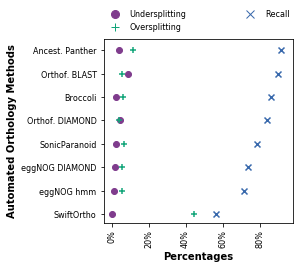

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import operator 
import matplotlib.ticker as mtick


re_names = {'eggnog_diamond': 'eggNOG DIAMOND',\
'eggnog_hmmer_corrected': 'eggNOG hmm',\
'orthofinder_diamond_e-3': 'Orthof. DIAMOND',\
'orthofinder_blast_e-3': 'Orthof. BLAST',\
'panther_corrected': 'Ancest. Panther',\
'sonicparanoid_sensitive': 'SonicParanoid',\
'swiftortho': 'SwiftOrtho',\
'broccoli': 'Broccoli'}

color_list = ['#7F3C8D','#11A579','#3969AC','#F2B701','#E73F74','#80BA5A','#E68310','#008695','#CF1C90',\
              '#f97b72','#4b4b8f','#A5AA99','#000000']


fig = plt.figure(figsize = (one_column, one_column))

for ogdefs in sorted(total_assigned.items(), key=operator.itemgetter(1)):
    ogdef = ogdefs[0] 
    ax = fig.add_subplot(1,1,1)
    ax.scatter(undersplit_total[ogdef], re_names[ogdef], color = color_list[0])
    ax.scatter(oversplit_total[ogdef], re_names[ogdef], color = color_list[1], marker = "+")
    ax.scatter(total_assigned[ogdef], re_names[ogdef], color = color_list[2], marker = "x")

    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

custom_legend = [Line2D([0], [0], marker='o', color=color_list[0], label="Undersplitting",\
                          markerfacecolor=color_list[0], markersize=8, linestyle = 'none'),\
                 Line2D([0], [0], marker='+', color=color_list[1], label="Oversplitting",\
                          markerfacecolor=color_list[0], markersize=8, linestyle = 'none'),\
                 Line2D([0], [0], marker='x', color=color_list[2], label="Recall",\
                          markerfacecolor=color_list[2], markersize=8, linestyle = 'none')]

plt.legend(custom_legend, ["Undersplitting", "Oversplitting", "Recall"],\
           loc = 3, ncol = 2, prop={'size': 8}, mode = 'expand',\
           bbox_to_anchor = (0., 1.02, 1., .102),\
           borderaxespad=0., frameon = False)

plt.xticks(rotation = 90, size = 8)
plt.yticks(size = 8)
plt.xlabel("Percentages", size=10, fontweight = "bold")
plt.ylabel("Automated Orthology Methods", size=10, fontweight = "bold") 

file_name = "./Figures/Manuscript/split_scores.pdf"
plt.savefig(file_name, bbox_inches = 'tight',pad_inches = 0.05, format='pdf',\
                transparent = True)

In [39]:
#Get the sum times the number of orthologies that have score >0 
#(penalty for having over splitting in more ortholgoies)
file_over = "./Results/Tables_out/Over_split_score.csv"

file_over = open(file_over, "a")
for manual, ortho_d in oversplit_M.items():
    value_list = 0
    ortho_count = 0
    for ortho, value in ortho_d.items():
        if value > 0:
            value_list += value
            ortho_count += 1
    file_over.write("\t".join([manual, str(value_list*ortho_count), "\n"]))
file_over.close()

### ARS Heatmap

In [12]:
import pandas as pd
import numpy as np
re_names_ars = {'eggnog_diamond' : 'eggNOG DIAMOND',\
                'eggnog_hmmer_corrected': 'eggNOG hmm',\
                'orthofinder_blast_e-3': 'Orthofinder BLAST',\
                'orthofinder_diamond_e-3': 'Orthofinder DIAMOND',\
                'panther_corrected': 'Ancestral Panther',\
                'manual': 'Manual', 
                'sonicparanoid_sensitive': 'SonicParanoid',\
                'swiftortho': 'SwiftOrtho',\
                'broccoli': "Broccoli"}

print(re_names_ars)


{'eggnog_diamond': 'eggNOG DIAMOND', 'eggnog_hmmer_corrected': 'eggNOG hmm', 'orthofinder_blast_e-3': 'Orthofinder BLAST', 'orthofinder_diamond_e-3': 'Orthofinder DIAMOND', 'panther_corrected': 'Ancestral Panther', 'manual': 'Manual', 'sonicparanoid_sensitive': 'SonicParanoid', 'swiftortho': 'SwiftOrtho', 'broccoli': 'Broccoli'}


In [13]:
# Now for LECA OGs calculate the ARS

col_row_names = sorted(Orthologies_leca_ogs.keys())
col_row_names

n_ogdefs = len(col_row_names)

ogdef_ars_matrix_all_ogs = np.empty((n_ogdefs,n_ogdefs))
ogdef_ars_matrix_all_ogs.fill(np.nan)

for x in range(n_ogdefs):
    for y in range(n_ogdefs):
        if x == y:
            ogdef_ars_matrix_all_ogs[x][y] = 1.0
        else:
            ogdef_x = col_row_names[x]
            ogdef_y = col_row_names[y]
            intersect = set(Orthologies_leca_ogs[ogdef_x].keys()).intersection(set(Orthologies_leca_ogs[ogdef_y].keys()))
            x_ogid_labels = [Orthologies_leca_ogs[ogdef_x][id] for id in intersect]
            y_ogid_labels = [Orthologies_leca_ogs[ogdef_y][id] for id in intersect]
            ars = adjusted_rand_score(x_ogid_labels,y_ogid_labels)
            ogdef_ars_matrix_all_ogs[x][y] = ars
            logger.info("{} vs. {} = {}".format(ogdef_x, ogdef_y, ars))
            
ogdef_ars_matrix_all_ogs_df = pd.DataFrame(ogdef_ars_matrix_all_ogs, index = col_row_names, columns=col_row_names)
ogdef_ars_matrix_all_ogs_df.to_csv("./Results/Tables_out/ARS_allvsall_leca.csv", sep="\t", )
ogdef_ars_matrix_all_ogs_df

2020-04-16 13:54:29 INFO     broccoli vs. eggnog_diamond = 0.503405792784113
2020-04-16 13:54:32 INFO     broccoli vs. eggnog_hmmer_corrected = 0.5070692338566649
2020-04-16 13:54:32 INFO     broccoli vs. manual = 0.8915225170284916
2020-04-16 13:54:35 INFO     broccoli vs. orthofinder_blast_e-3 = 0.4180908007179559
2020-04-16 13:54:37 INFO     broccoli vs. orthofinder_diamond_e-3 = 0.4710418987608569
2020-04-16 13:54:41 INFO     broccoli vs. panther_corrected = 0.39421617803135717
2020-04-16 13:54:44 INFO     broccoli vs. sonicparanoid_sensitive = 0.4762099164412919
2020-04-16 13:54:45 INFO     broccoli vs. swiftortho = 0.33510803049854276
2020-04-16 13:54:48 INFO     eggnog_diamond vs. broccoli = 0.503405792784113
2020-04-16 13:54:50 INFO     eggnog_diamond vs. eggnog_hmmer_corrected = 0.7282034697671891
2020-04-16 13:54:50 INFO     eggnog_diamond vs. manual = 0.9359641875490256
2020-04-16 13:54:53 INFO     eggnog_diamond vs. orthofinder_blast_e-3 = 0.5463401905764736
2020-04-16 13:5

KeyboardInterrupt: 

In [99]:
import numpy as np
ARS_matrix = pd.read_csv("./Results/Tables_out/ARS_allvsall_leca.csv", sep="\t", index_col=0)
ARS_matrix = ARS_matrix.rename(columns=re_names_ars,\
          index=re_names_ars)
mean_df = np.mean(ARS_matrix.mask(np.equal(*np.indices(ARS_matrix.shape))))
print(mean_df.loc["Manual",])
print(np.mean(mean_df.drop("Manual")))

#reorder matrix
cols = list(ARS_matrix.columns.values)
cols.remove("Manual")
cols = ["Manual", " "] + cols #Need manual at front
cols.remove("SwiftOrtho") #Don't need this as a column, just a row
ARS_matrix = ARS_matrix.loc[ARS_matrix.index != "Manual",cols]


0.8527574140125763
0.5225777933405299


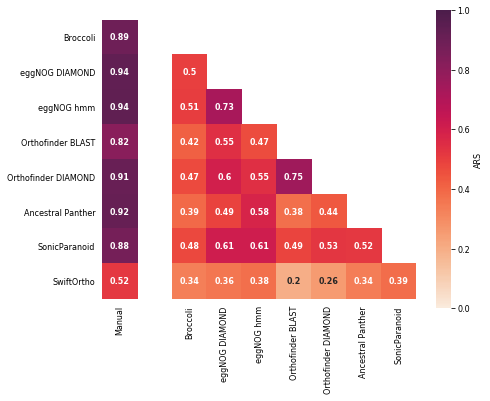

In [44]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams.update({'figure.autolayout': True})

cmap = sns.cm.rocket_r

from seaborn import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
autumn = cm.rocket_r
newcolors = autumn(np.linspace(0, 0.8, 256))#[::-1]

white = np.array([1, 1, 1, 1])
newcolors[0, :] = white
newcmp = ListedColormap(newcolors)

#mask for the upper half of diagonal
mask = np.zeros_like(ARS_matrix, dtype=np.bool)
#use k is one to keep diagonal values
mask[np.triu_indices_from(mask, k=2)] = True

fig = plt.figure(figsize = (two_column,0.80*two_column))


hmap = sns.heatmap(ARS_matrix, vmin=0, vmax=1, mask = mask, cmap = newcmp,\
                  annot = True, annot_kws={"size": 8, 'weight': 'bold'},\
                  cbar = True, square = True, cbar_kws={'label': 'ARS'})#.set_title("Adjusted Rand Score LECA OGs")

plt.tight_layout()
plt.tick_params(left = False, bottom = False)
fig.savefig("./Figures/Manuscript/ARS_leca_heatmap_2col.pdf",\
            bbox_inches = 'tight',pad_inches = 0.05, format='pdf',transparent = True)